# Titanic - 確率ベースアンサンブル (NO DATA LEAKAGE)

このノートブックは、CatBoost, XGBoost, RandomForestの3モデルを**確率ベース**でアンサンブルします。

## 🎯 改善点:
- ✅ **predict_proba()を使用**: ハードラベル(0,1)ではなく確率(0.0~1.0)でアンサンブル
- ✅ **データリーク完全防止**: Ticket_Frequency, Age補完を訓練データのみで計算
- ✅ **Stratified K-Fold**: クラス比率を保持した交差検証

## 1. セットアップとデータ読み込み

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
import pickle
from typing import Dict, List, Tuple
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 定数設定
RANDOM_STATE = 42
N_FOLDS = 5

# 乱数シード固定
np.random.seed(RANDOM_STATE)

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [2]:
# データ読み込み
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTarget distribution:")
print(df_train['Perished'].value_counts(normalize=True))

df_train.head()

Train shape: (891, 12)
Test shape: (418, 11)

Target distribution:
Perished
1    0.616162
0    0.383838
Name: proportion, dtype: float64


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. 特徴量エンジニアリング (データリーク修正版)

In [3]:
def extract_surname(data):
    """名前から姓を抽出"""
    families = []
    
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
        
        family = name_no_bracket.split(',')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
    
    return families


def create_features(df_train, df_test):
    """
    特徴量エンジニアリングを実行（データリーク完全防止版）
    """
    train = df_train.copy()
    test = df_test.copy()
    
    all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
    train_idx = ~all_data['Perished'].isna()
    
    print("特徴量エンジニアリング開始...")
    print("🔒 データリーク対策を適用中...\n")
    
    # 1. Title（敬称）抽出
    all_data['Title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    all_data['Title'] = all_data['Title'].replace(
        ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms'
    )
    all_data['Title'] = all_data['Title'].replace(
        ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy'
    )
    
    # 2. 結婚フラグ
    all_data['Is_Married'] = 0
    all_data.loc[all_data['Title'] == 'Mrs', 'Is_Married'] = 1
    
    # 3. Family（姓）
    all_data['Family'] = extract_surname(all_data['Name'])
    
    # 4. Family_Size（家族サイズ）
    all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
    
    # 5. Family_Size_Grouped（家族サイズのビン化）
    family_map = {
        1: 'Alone',
        2: 'Small', 3: 'Small', 4: 'Small',
        5: 'Medium', 6: 'Medium',
        7: 'Large', 8: 'Large', 11: 'Large'
    }
    all_data['Family_Size_Grouped'] = all_data['Family_Size'].map(family_map)
    
    # 6. Ticket_Frequency - 🔒 訓練データのみで計算
    print("🔒 [修正] Ticket_Frequency: 訓練データのみで計算")
    train_ticket_freq = all_data.loc[train_idx].groupby('Ticket')['Ticket'].transform('count')
    train_ticket_map = all_data.loc[train_idx].groupby('Ticket').size().to_dict()
    
    all_data.loc[train_idx, 'Ticket_Frequency'] = train_ticket_freq
    all_data.loc[~train_idx, 'Ticket_Frequency'] = all_data.loc[~train_idx, 'Ticket'].map(train_ticket_map).fillna(1)
    
    # 7. Deck（デッキ）
    all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
    all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
    all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')
    all_data['Deck'] = all_data['Deck'].replace(['T'], 'M')
    
    # 8. Age補完と離散化 - 🔒 訓練データのみから統計量計算
    print("🔒 [修正] Age補完: 訓練データのみの統計量を使用")
    all_data['Age'] = pd.to_numeric(all_data['Age'], errors='coerce')
    age_by_pclass_sex = all_data.loc[train_idx].groupby(['Sex', 'Pclass'])['Age'].median()
    
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            mask = (all_data['Age'].isnull()) & (all_data['Pclass'] == pclass) & (all_data['Sex'] == sex)
            all_data.loc[mask, 'Age'] = age_by_pclass_sex.loc[(sex, pclass)]
    
    all_data['Age_Band'] = pd.cut(all_data['Age'], bins=[0, 12, 18, 30, 50, 80], 
                                    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 9. Fare補完と離散化
    print("✅ [OK] Fare補完: 訓練データのみの統計量を使用")
    train_fare_median = all_data.loc[train_idx, 'Fare'].median()
    all_data['Fare'] = all_data['Fare'].fillna(train_fare_median)
    
    train_fare_quantiles = all_data.loc[train_idx, 'Fare'].quantile([0.25, 0.5, 0.75]).values
    all_data['Fare_Band'] = pd.cut(
        all_data['Fare'],
        bins=[-np.inf] + train_fare_quantiles.tolist() + [np.inf],
        labels=['Low', 'Medium', 'High', 'Very_High']
    )
    
    # 10. Embarked補完
    all_data['Embarked'] = all_data['Embarked'].fillna('S')
    
    # 11. Sex x Pclass 交互作用
    all_data['Sex_Pclass'] = all_data['Sex'] + '_' + all_data['Pclass'].astype(str)
    
    print(f"\n✅ 特徴量作成完了: {all_data.shape[1]} columns")
    print("✅ データリーク完全防止版")
    
    train_processed = all_data[train_idx].reset_index(drop=True)
    test_processed = all_data[~train_idx].reset_index(drop=True)
    
    return train_processed, test_processed


train_df, test_df = create_features(df_train, df_test)

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

特徴量エンジニアリング開始...
🔒 データリーク対策を適用中...

🔒 [修正] Ticket_Frequency: 訓練データのみで計算
🔒 [修正] Age補完: 訓練データのみの統計量を使用
✅ [OK] Fare補完: 訓練データのみの統計量を使用

✅ 特徴量作成完了: 22 columns
✅ データリーク完全防止版

Train shape: (891, 22)
Test shape: (418, 22)



X shape: (891, 8)
y shape: (891,)
X_test shape: (418, 8)

✅ No data leakage

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']

X shape: (891, 8)
y shape: (891,)
X_test shape: (418, 8)

✅ No data leakage

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']

X shape: (891, 8)
y shape: (891,)
X_test shape: (418, 8)

✅ No data leakage

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']


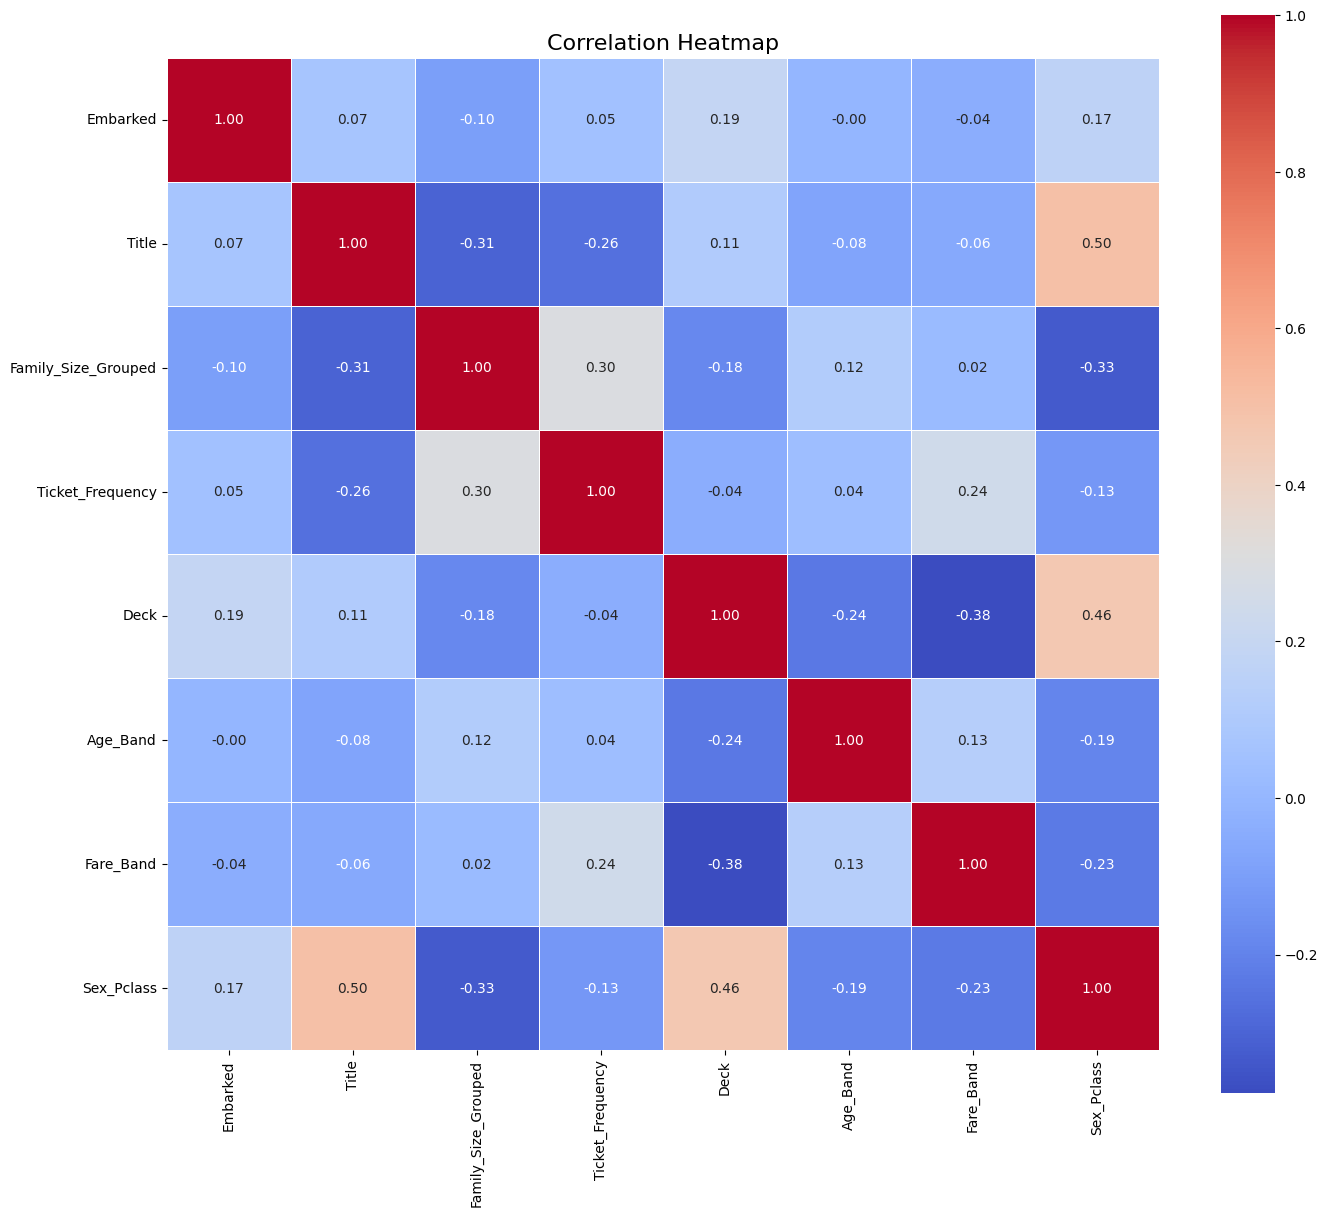

In [4]:
def prepare_data(train_df, test_df):
    """
    データを機械学習モデル用に準備（データリークなし）
    """
    feature_cols = [
        #'Pclass',  'Family_Size',
        'Embarked', 'Title',
        'Family_Size_Grouped', 'Ticket_Frequency', 'Deck',
        'Age_Band', 'Fare_Band', 'Sex_Pclass'
    ]
    
    train = train_df[feature_cols + ['Perished']].copy()
    test = test_df[feature_cols].copy()
    
    cat_features = ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']
    
    le_dict = {}
    for col in cat_features:
        le = LabelEncoder()
        le.fit(train[col].astype(str))
        
        train[col] = le.transform(train[col].astype(str))
        
        test_col_str = test[col].astype(str)
        unknown_mask = ~test_col_str.isin(le.classes_)
        
        if unknown_mask.any():
            most_frequent = train_df[col].mode()[0]
            test.loc[unknown_mask, col] = most_frequent
            print(f"  Warning: {col} has {unknown_mask.sum()} unknown categories in test")
        
        test[col] = le.transform(test[col].astype(str))
        le_dict[col] = le
    
    X = train.drop('Perished', axis=1)
    y = train['Perished']
    X_test = test
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"\n✅ No data leakage")
    
    return X, y, X_test, cat_features


X, y, X_test, cat_features = prepare_data(train_df, test_df)
print(f"\nCategorical features: {cat_features}")


X, y, X_test, cat_features = prepare_data(train_df, test_df)
print(f"\nCategorical features: {cat_features}")



X, y, X_test, cat_features = prepare_data(train_df, test_df)

print(f"\nCategorical features: {cat_features}")


corr = X.select_dtypes(include='number').corr()

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    annot=True,          # ★数値を表示
    fmt=".2f",           # ★小数点2桁
    cmap="coolwarm",
    square=True,
    linewidths=0.5,      # 枠線
    cbar=True            # カラーバー
)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()      

## 3. 最適なハイパーパラメータ設定

In [ ]:
# 各モデルの最適なハイパーパラメータ

# RandomForest
best_params_randomforest = {
    'n_estimators': 1200,
    'max_depth': 6,                 # ★浅く
    'min_samples_split': 6,
    'min_samples_leaf': 3,          # ★汎化UP
    'max_features': 'sqrt',
    'bootstrap': True,
    'max_samples': 0.9,
    'criterion': 'gini',
    'class_weight': None,           # ★ balanced は外す
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}


# CatBoost
# best_params_catboost = {
#     'iterations': 500,
#     'learning_rate': 0.05,
#     'depth': 6,
#     'l2_leaf_reg': 3.0,
#     'border_count': 128,
#     'random_strength': 1.0,
#     'bagging_temperature': 0.5,
#     'subsample': 0.8,
#     'min_data_in_leaf': 10,
#     'max_leaves': 31,
#     'leaf_estimation_iterations': 5,
#     'random_state': RANDOM_STATE,
#     'verbose': 0,
#     'task_type': 'CPU'
# }
best_params_catboost = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 6.0,
    'border_count': 128,          # 多すぎると過学習気味になりやすい
    'bagging_temperature': 0.5,   # 0.3〜1.0 を探索
    'random_strength': 1.0,
    'rsm': 0.9,                   # 列サブサンプル
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_state': RANDOM_STATE,
    'verbose': 0
}



# XGBoost
best_params_xgboost = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 3,
    'gamma': 0.1,
    'max_delta_step': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': 1.0,
    'max_bin': 256,
    'random_state': RANDOM_STATE,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}


print("="*60)
print("最適なハイパーパラメータを設定完了")
print("="*60)
print("\nRandomForest, CatBoost, XGBoost の3モデルを使用")

最適なハイパーパラメータを設定完了

RandomForest, CatBoost, XGBoost の3モデルを使用


## 4. Stratified K-Fold学習 (確率ベース)

In [6]:
def train_top3_models_proba(X, y, X_test, n_folds=5):
    """
    Top 3モデル（RandomForest, CatBoost, XGBoost）をStratified K-Foldで学習
    🎯 predict_proba() を使用した確率ベースのアンサンブル
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # 🎯 確率を保存 (0.0 ~ 1.0)
    oof_proba_rf = np.zeros(len(X))
    oof_proba_cat = np.zeros(len(X))
    oof_proba_xgb = np.zeros(len(X))
    
    test_proba_rf = np.zeros((len(X_test), n_folds))
    test_proba_cat = np.zeros((len(X_test), n_folds))
    test_proba_xgb = np.zeros((len(X_test), n_folds))
    
    models_rf = []
    models_cat = []
    models_xgb = []
    
    # 過学習チェック用
    train_scores = {'rf': [], 'cat': [], 'xgb': []}
    valid_scores = {'rf': [], 'cat': [], 'xgb': []}
    
    print("="*60)
    print("🎯 確率ベースアンサンブル - Stratified K-Fold Training")
    print("="*60)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_folds}")
        print(f"{'='*60}")
        
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # RandomForest
        print("\n[1/3] Training RandomForest...")
        model_rf = RandomForestClassifier(**best_params_randomforest)
        model_rf.fit(X_train, y_train)
        
        # 🎯 predict_proba() を使用 (確率)
        oof_proba_rf[valid_idx] = model_rf.predict_proba(X_valid)[:, 1]
        test_proba_rf[:, fold] = model_rf.predict_proba(X_test)[:, 1]
        models_rf.append(model_rf)
        
        # 評価用にハードラベルも計算
        train_preds_rf = model_rf.predict(X_train)
        valid_preds_rf = model_rf.predict(X_valid)
        
        train_acc_rf = accuracy_score(y_train, train_preds_rf)
        valid_acc_rf = accuracy_score(y_valid, valid_preds_rf)
        train_scores['rf'].append(train_acc_rf)
        valid_scores['rf'].append(valid_acc_rf)
        
        print(f"  Train Accuracy: {train_acc_rf:.4f}")
        print(f"  Valid Accuracy: {valid_acc_rf:.4f}")
        print(f"  Overfit Gap:    {train_acc_rf - valid_acc_rf:.4f}")
        
        # CatBoost
        print("\n[2/3] Training CatBoost...")
        model_cat = CatBoostClassifier(**best_params_catboost)
        model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=0)
        
        # 🎯 predict_proba() を使用 (確率)
        oof_proba_cat[valid_idx] = model_cat.predict_proba(X_valid)[:, 1]
        test_proba_cat[:, fold] = model_cat.predict_proba(X_test)[:, 1]
        models_cat.append(model_cat)
        
        train_preds_cat = model_cat.predict(X_train)
        valid_preds_cat = model_cat.predict(X_valid)
        
        train_acc_cat = accuracy_score(y_train, train_preds_cat)
        valid_acc_cat = accuracy_score(y_valid, valid_preds_cat)
        train_scores['cat'].append(train_acc_cat)
        valid_scores['cat'].append(valid_acc_cat)
        
        print(f"  Train Accuracy: {train_acc_cat:.4f}")
        print(f"  Valid Accuracy: {valid_acc_cat:.4f}")
        print(f"  Overfit Gap:    {train_acc_cat - valid_acc_cat:.4f}")
        
        # XGBoost
        print("\n[3/3] Training XGBoost...")
        model_xgb = XGBClassifier(**best_params_xgboost)
        model_xgb.fit(
            X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=0,
            early_stopping_rounds=50
        )
        
        # 🎯 predict_proba() を使用 (確率)
        oof_proba_xgb[valid_idx] = model_xgb.predict_proba(X_valid)[:, 1]
        test_proba_xgb[:, fold] = model_xgb.predict_proba(X_test)[:, 1]
        models_xgb.append(model_xgb)
        
        train_preds_xgb = model_xgb.predict(X_train)
        valid_preds_xgb = model_xgb.predict(X_valid)
        
        train_acc_xgb = accuracy_score(y_train, train_preds_xgb)
        valid_acc_xgb = accuracy_score(y_valid, valid_preds_xgb)
        train_scores['xgb'].append(train_acc_xgb)
        valid_scores['xgb'].append(valid_acc_xgb)
        
        print(f"  Train Accuracy: {train_acc_xgb:.4f}")
        print(f"  Valid Accuracy: {valid_acc_xgb:.4f}")
        print(f"  Overfit Gap:    {train_acc_xgb - valid_acc_xgb:.4f}")
    
    # CV結果サマリー
    print(f"\n{'='*60}")
    print("Cross-Validation Results (Mean ± Std)")
    print(f"{'='*60}")
    
    for name, key in [('RandomForest', 'rf'), ('CatBoost', 'cat'), ('XGBoost', 'xgb')]:
        train_mean = np.mean(train_scores[key])
        train_std = np.std(train_scores[key])
        valid_mean = np.mean(valid_scores[key])
        valid_std = np.std(valid_scores[key])
        gap = train_mean - valid_mean
        
        print(f"\n{name}:")
        print(f"  Train: {train_mean:.4f} ± {train_std:.4f}")
        print(f"  Valid: {valid_mean:.4f} ± {valid_std:.4f}")
        print(f"  Gap:   {gap:.4f} {'⚠️ OVERFITTING' if gap > 0.05 else '✓ Good'}")
    
    # 🎯 確率ベースのOOFスコア
    print(f"\n{'='*60}")
    print("Out-of-Fold Scores (Probability-based)")
    print(f"{'='*60}")
    print(f"RandomForest: {accuracy_score(y, (oof_proba_rf >= 0.5).astype(int)):.4f}")
    print(f"CatBoost:     {accuracy_score(y, (oof_proba_cat >= 0.5).astype(int)):.4f}")
    print(f"XGBoost:      {accuracy_score(y, (oof_proba_xgb >= 0.5).astype(int)):.4f}")
    
    return {
        'oof_proba_rf': oof_proba_rf,
        'oof_proba_cat': oof_proba_cat,
        'oof_proba_xgb': oof_proba_xgb,
        'test_proba_rf': test_proba_rf.mean(axis=1),
        'test_proba_cat': test_proba_cat.mean(axis=1),
        'test_proba_xgb': test_proba_xgb.mean(axis=1),
        'models_rf': models_rf,
        'models_cat': models_cat,
        'models_xgb': models_xgb,
        'train_scores': train_scores,
        'valid_scores': valid_scores
    }


# 学習実行
results = train_top3_models_proba(X, y, X_test, n_folds=N_FOLDS)

🎯 確率ベースアンサンブル - Stratified K-Fold Training

Fold 1/5

[1/3] Training RandomForest...
  Train Accuracy: 0.8666
  Valid Accuracy: 0.8324
  Overfit Gap:    0.0342

[2/3] Training CatBoost...
  Train Accuracy: 0.8820
  Valid Accuracy: 0.8492
  Overfit Gap:    0.0329

[3/3] Training XGBoost...
  Train Accuracy: 0.8680
  Valid Accuracy: 0.8324
  Overfit Gap:    0.0356

Fold 2/5

[1/3] Training RandomForest...
  Train Accuracy: 0.8780
  Valid Accuracy: 0.8371
  Overfit Gap:    0.0409

[2/3] Training CatBoost...
  Train Accuracy: 0.8682
  Valid Accuracy: 0.8258
  Overfit Gap:    0.0423

[3/3] Training XGBoost...
  Train Accuracy: 0.8654
  Valid Accuracy: 0.8315
  Overfit Gap:    0.0339

Fold 3/5

[1/3] Training RandomForest...
  Train Accuracy: 0.8808
  Valid Accuracy: 0.8146
  Overfit Gap:    0.0662

[2/3] Training CatBoost...
  Train Accuracy: 0.8808
  Valid Accuracy: 0.8146
  Overfit Gap:    0.0662

[3/3] Training XGBoost...
  Train Accuracy: 0.8752
  Valid Accuracy: 0.8371
  Overfit Gap:  

## 5. 確率ベースアンサンブル予測と提出

In [7]:
# 🎯 確率ベースアンサンブル（単純平均）
ensemble_proba = (
    results['oof_proba_xgb'] +
    results['oof_proba_cat'] +
    results['oof_proba_rf']
) / 3

ensemble_oof_score = accuracy_score(y, (ensemble_proba >= 0.5).astype(int))

print("="*60)
print("🎯 確率ベースアンサンブル - OOF Performance")
print("="*60)
print(f"\n個別モデル:")
print(f"  RandomForest: {accuracy_score(y, (results['oof_proba_rf'] >= 0.5).astype(int)):.4f}")
print(f"  CatBoost:     {accuracy_score(y, (results['oof_proba_cat'] >= 0.5).astype(int)):.4f}")
print(f"  XGBoost:      {accuracy_score(y, (results['oof_proba_xgb'] >= 0.5).astype(int)):.4f}")
print(f"\n🎯 確率ベースアンサンブル:")
print(f"  Ensemble OOF: {ensemble_oof_score:.4f}")

best_single = max(
    accuracy_score(y, (results['oof_proba_rf'] >= 0.5).astype(int)),
    accuracy_score(y, (results['oof_proba_cat'] >= 0.5).astype(int)),
    accuracy_score(y, (results['oof_proba_xgb'] >= 0.5).astype(int))
)
improvement = ensemble_oof_score - best_single
print(f"\n最良単一モデルとの差: {improvement:+.4f}")

if improvement > 0:
    print(f"✅ アンサンブルで {improvement:.4f} 改善！")
else:
    print(f"⚠️ 改善なし (確率ベースでも改善幅小)")

# LogLoss比較
print(f"\n{'='*60}")
print("LogLoss (確率の質を評価)")
print(f"{'='*60}")
print(f"RandomForest: {log_loss(y, results['oof_proba_rf']):.4f}")
print(f"CatBoost:     {log_loss(y, results['oof_proba_cat']):.4f}")
print(f"XGBoost:      {log_loss(y, results['oof_proba_xgb']):.4f}")
print(f"Ensemble:     {log_loss(y, ensemble_proba):.4f}")

🎯 確率ベースアンサンブル - OOF Performance

個別モデル:
  RandomForest: 0.8305
  CatBoost:     0.8294
  XGBoost:      0.8339

🎯 確率ベースアンサンブル:
  Ensemble OOF: 0.8328

最良単一モデルとの差: -0.0011
⚠️ 改善なし (確率ベースでも改善幅小)

LogLoss (確率の質を評価)
RandomForest: 0.4000
CatBoost:     0.3890
XGBoost:      0.3899
Ensemble:     0.3887


In [8]:
# 🎯 テスト予測（確率ベース）
test_ensemble_proba = (
    results['test_proba_xgb'] +
    results['test_proba_cat'] +
    results['test_proba_rf']
) / 3

final_predictions = (test_ensemble_proba >= 0.5).astype(int)

print("="*60)
print("Test Predictions (Probability-based Ensemble)")
print("="*60)
print(f"Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
print(f"Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

# 確率の統計情報
print(f"\n確率分布の統計:")
print(f"  Mean: {test_ensemble_proba.mean():.4f}")
print(f"  Std:  {test_ensemble_proba.std():.4f}")
print(f"  Min:  {test_ensemble_proba.min():.4f}")
print(f"  Max:  {test_ensemble_proba.max():.4f}")

Test Predictions (Probability-based Ensemble)
Survived (0): 157 (37.6%)
Perished (1): 261 (62.4%)

確率分布の統計:
  Mean: 0.5836
  Std:  0.3307
  Min:  0.0204
  Max:  0.9487


In [9]:
# 提出ファイル作成
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Perished': final_predictions
})

os.makedirs('../output', exist_ok=True)
output_path = '../output/submission_proba_ensemble.csv'
submission.to_csv(output_path, index=False)

print(f"\n提出ファイルを保存: {output_path}")
print(f"\n最初の10行:")
print(submission.head(10))


提出ファイルを保存: ../output/submission_proba_ensemble.csv

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1


In [10]:
# モデル保存
model_save_path = '../output/models_proba_ensemble.pkl'

with open(model_save_path, 'wb') as f:
    pickle.dump({
        'models_rf': results['models_rf'],
        'models_cat': results['models_cat'],
        'models_xgb': results['models_xgb'],
        'best_params_rf': best_params_randomforest,
        'best_params_cat': best_params_catboost,
        'best_params_xgb': best_params_xgboost
    }, f)

print(f"\nモデルを保存: {model_save_path}")


モデルを保存: ../output/models_proba_ensemble.pkl


## 6. Feature Importance分析

In [11]:
# Feature Importance（3モデルの平均）

feature_names = X.columns.tolist()

# RandomForest
rf_importance = np.mean([m.feature_importances_ for m in results['models_rf']], axis=0)

# CatBoost
cat_importance = np.mean([m.get_feature_importance() for m in results['models_cat']], axis=0)

# XGBoost
xgb_importance = np.mean([m.feature_importances_ for m in results['models_xgb']], axis=0)

# 平均
avg_importance = (rf_importance + cat_importance + xgb_importance) / 3

df_fi = pd.DataFrame({
    'feature': feature_names,
    'rf': rf_importance,
    'cat': cat_importance,
    'xgb': xgb_importance,
    'avg': avg_importance
}).sort_values('avg', ascending=False)

print("="*60)
print("Feature Importance (Top 3 Models Average)")
print("="*60)
print(df_fi.head(10))

Feature Importance (Top 3 Models Average)
               feature        rf        cat       xgb       avg
7           Sex_Pclass  0.300446  25.497942  0.289139  8.695842
1                Title  0.283731  23.055925  0.360987  7.900214
3     Ticket_Frequency  0.095800  10.355166  0.084865  3.511944
2  Family_Size_Grouped  0.074601   9.824654  0.054688  3.317981
5             Age_Band  0.059255   8.731198  0.047995  2.946150
6            Fare_Band  0.065504   8.718229  0.043816  2.942516
4                 Deck  0.081906   8.386716  0.075409  2.848011
0             Embarked  0.038756   5.430169  0.043102  1.837342


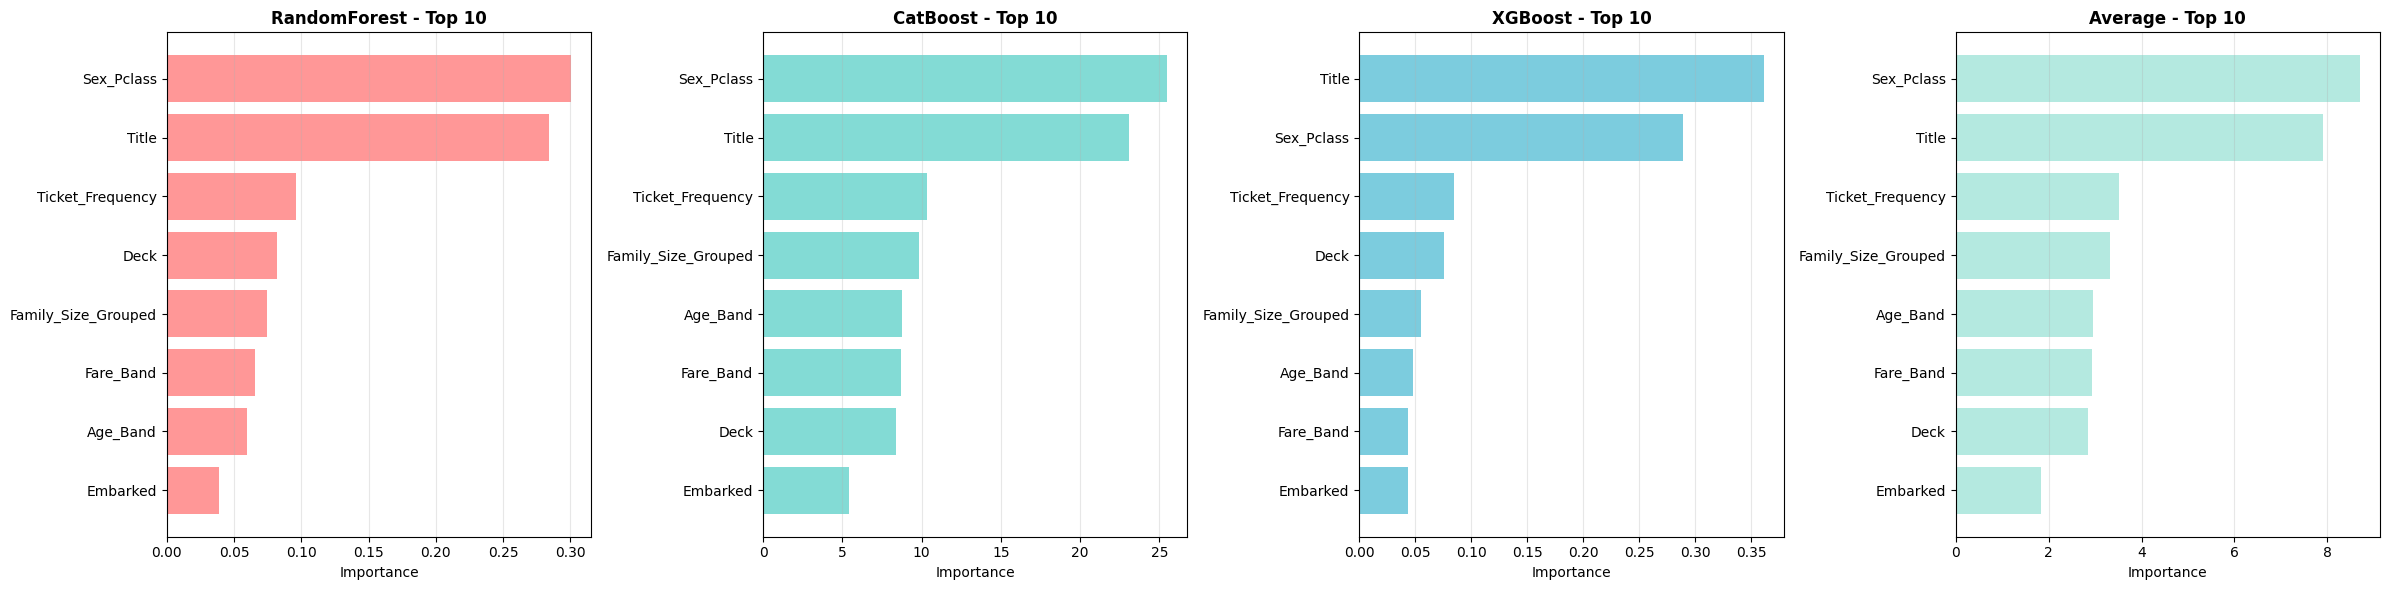


Feature Importance plot saved: ../output/feature_importance_proba.png


In [12]:
# Feature Importance可視化

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for idx, (col, title, color) in enumerate(zip(
    ['rf', 'cat', 'xgb', 'avg'],
    ['RandomForest', 'CatBoost', 'XGBoost', 'Average'],
    ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3']
)):
    top10 = df_fi.nlargest(10, col)
    axes[idx].barh(range(len(top10)), top10[col].values, color=color, alpha=0.7)
    axes[idx].set_yticks(range(len(top10)))
    axes[idx].set_yticklabels(top10['feature'].values)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{title} - Top 10', fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/feature_importance_proba.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Importance plot saved: ../output/feature_importance_proba.png")

In [13]:
print("\n" + "="*60)
print("すべての処理が完了しました!")
print("="*60)
print(f"\n最終結果:")
print(f"  RandomForest OOF: {accuracy_score(y, (results['oof_proba_rf'] >= 0.5).astype(int)):.4f}")
print(f"  CatBoost OOF:     {accuracy_score(y, (results['oof_proba_cat'] >= 0.5).astype(int)):.4f}")
print(f"  XGBoost OOF:      {accuracy_score(y, (results['oof_proba_xgb'] >= 0.5).astype(int)):.4f}")
print(f"  Ensemble OOF:     {ensemble_oof_score:.4f}")
print(f"\n🎯 確率ベースアンサンブル適用")
print(f"✅ データリーク完全防止版")
print(f"\n提出ファイル: {output_path}")
print(f"モデルファイル: {model_save_path}")


すべての処理が完了しました!

最終結果:
  RandomForest OOF: 0.8305
  CatBoost OOF:     0.8294
  XGBoost OOF:      0.8339
  Ensemble OOF:     0.8328

🎯 確率ベースアンサンブル適用
✅ データリーク完全防止版

提出ファイル: ../output/submission_proba_ensemble.csv
モデルファイル: ../output/models_proba_ensemble.pkl
